# Klasteryzacja

## Konfiguracja

Użyjemy standardowych bibliotek oraz dodatkowo:
- Plotly - do wizualizacji
- UMAP, HDBSCAN - implementacja algorytmów

**Uwaga:** upewnij się, że masz scikit-learn w wersji 1.2 lub nowszej (druga komórka poniżej). Dzięki temu będzie można ustawić opcję `transform_output="pandas"`, dzięki której wszystkie transformatory w scikit-learn będą nie tylko przyjmować, ale też zwracać DataFrame, zachowując nazwy zmiennych. Będzie to bardzo przydatne w analizie danych.

In [1]:
# !pip install numpy scipy pandas matplotlib scikit-learn missingno

In [2]:
# !pip install plotly umap-learn hdbscan

In [3]:
# !pip install -U scikit-learn

In [64]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [5]:
import sklearn


sklearn.set_config(transform_output="pandas")

## Analiza muzyki ze Spotify

Spotify w swoim API oferuje automatyczną [ekstrakcję cech z piosenek](https://developer.spotify.com/documentation/web-api/reference/get-audio-features), których można następnie użyć do wielu ciekawych analiz, jak np. [tutaj](https://rpubs.com/PeterDola/SpotifyTracks) lub [tutaj](https://rstudio-pubs-static.s3.amazonaws.com/604869_8399a2cf0e4a419da6272452c3d6a6d3.html). Datasetów jest wiele, z czego jednym z największych [jest dostępny tutaj na Kaggle](https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=tracks.csv) i zawiera ponad 600 tysięcy piosenek.

Cechy zwracane przez API to m. in. akustyczność, taneczność, energia, głośność czy długość piosenki. Pełna lista cech jest dostępna [w dokumentacji](https://developer.spotify.com/documentation/web-api/reference/get-audio-features). Są to bardzo dobre cechy do uczenia maszynowego - niewielka wymiarowość i tylko numeryczne. Wadą jest pewna dość mocna korelacja w niektórych podgatunkach muzycznych, ale akurat to w przypadku klasteryzacji takich danych jest całkiem ok, i może prowadzić do sensownych wniosków.

Spotify definiuje i wykorzystuje ponad 125 gatunków muzycznych, które na dodatek są dość dyskusyjne i płynne. Przykładowo, według różnych klasyfikacji Powerwolf, Ensiferum i Alestorm mogą wylądować w tym samym worku, pomimo zdecydowanie różnej muzyki. Klasteryzacja pozwala tworzyć "płynne" tagi, klasyfikując muzykę w dużo bardziej zniuansowany sposób.

**Uwaga:** zgodnie z licencją API danych nie można używać do treningu modeli ML. Oczywiście tego typu licencje nie dotyczą użytku prywatnego ani zastosowań naukowych, co wynika z ogólnych przepisów. Należy jednak pamiętać, że takich modeli nie wolno w żaden sposób publikować ani wykorzystywać komercyjnie.

**Zadanie 1 (2.5 punktu)**

1. Ściągnij pliki `artists.csv` oraz `tracks.csv` z Kaggle'a.
2. Załaduj pliki do zmiennych `df_artists` i `df_tracks`.
3. Usuń wiersze z wartościami brakującymi z obu ramek danych.
4. Ponad 600 tysięcy piosenek to zdecydowanie za dużo, a na dodatek przeważająca większość z nich to drobni, mało znani artyści. Aby to zweryfikować, narysuj histogramy popularności artystów oraz piosenek. Użyj 100 kubełków (bins). Pamiętaj o tytułach wykresów.
5. Pozostaw tylko artystów z popularnością minimum 55, oraz tylko piosenki z popularnością minimum 45.
6. Większość piosenek trwa kilka minut, ale są anomalie, które trwają bardzo długo. Pozostaw tylko te piosenki, które trwają co najwyżej 600.000 ms (10 minut).
7. Użyj podanej funkcji `extract_artist_id()` na ramce z piosenkami, która dodaje kolumnę `main_artist_id`.
8. Połącz ramki w jedną, `df_songs`, z wszystkimi informacjami:
   - użyj kolumn `main_artist_id` (ramka z piosenkami) oraz `id` (ramka z artystami)
   - przyda się `pd.merge()`
   - Pandas automatycznie dodaje sufiksy do kolumn (argument `suffixes`), żeby rozróżnić kolumny po takiej operacji JOIN
   - domyślnie są to mało znaczące `_x` i `_y`, zmień je na `_track` i `_artist`
9. Usuń duplikaty wedle kolumn `name_track` oraz `name_artist`.
10. Mamy kolumny z danymi, które identyfikują piosenki: nazwa piosenki, artysta, gatunki muzyczne. Nie są one jednak użyteczne do samej klasteryzacji. Wyodrębnij je do osobnej ramki `df_songs_info`.
```
songs_info_cols = [
    "name_track",
    "name_artist",
    "genres"
]
```
11. Stwórz nową ramkę `df_songs_features`, pozostawiając tylko kolumny z cechami do klasteryzacji:
```
songs_features_cols = [
    "duration_ms",
    "explicit",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "time_signature",
]
```
12. Wypisz finalną liczbę piosenek (rozmiar zbioru).

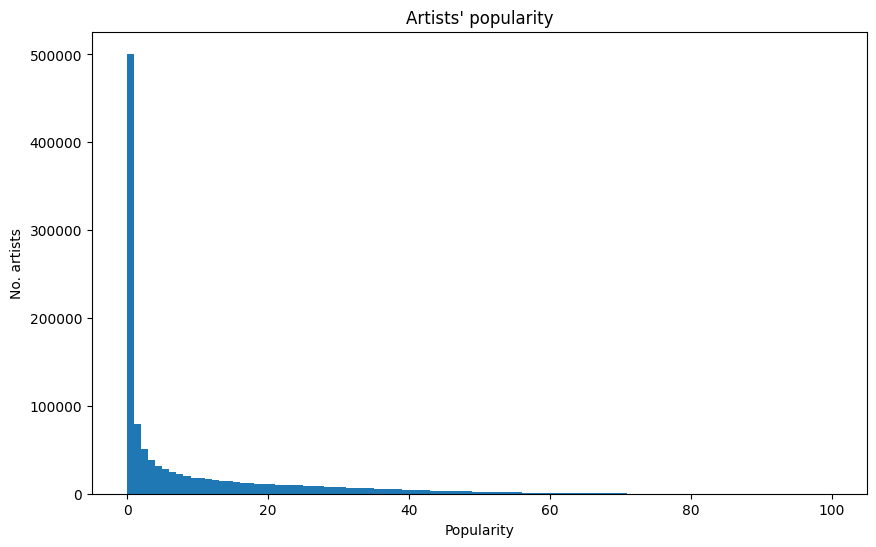

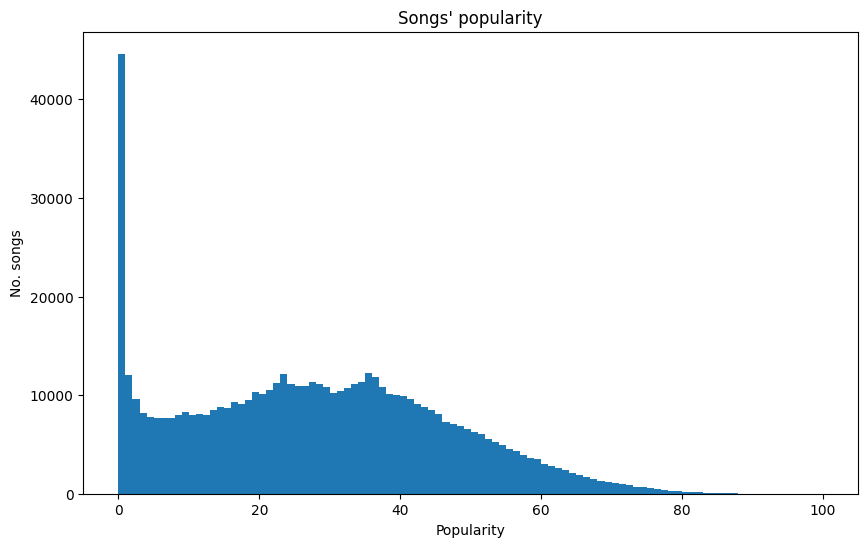

In [6]:
df_artists = pd.read_csv("artists.csv")
df_tracks = pd.read_csv("tracks.csv")
df_artists = df_artists.dropna()
df_tracks = df_tracks.dropna()

plt.figure(figsize=(10, 6))
plt.hist(df_artists["popularity"], bins=100)
plt.xlabel("Popularity")
plt.ylabel("No. artists")
plt.title("Artists' popularity")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df_tracks["popularity"], bins=100)
plt.xlabel("Popularity")
plt.ylabel("No. songs")
plt.title("Songs' popularity")
plt.show()

df_artists = df_artists[df_artists["popularity"] >= 55]
df_tracks = df_tracks[df_tracks["popularity"] >= 45]

df_tracks = df_tracks[df_tracks["duration_ms"] <= 600000]

In [7]:
import ast


def extract_artist_id(df_tracks: pd.DataFrame) -> pd.DataFrame:
    df_tracks["main_artist_id"] = df_tracks["id_artists"].apply(
        lambda x: ast.literal_eval(x)[0]
    )
    return df_tracks


df_tracks = extract_artist_id(df_tracks)

df_songs = pd.merge(
    df_tracks,
    df_artists,
    left_on="main_artist_id",
    right_on="id",
    suffixes=("_track", "_artist"),
)

df_songs = df_songs.drop("id_artist", axis=1)
songs_info_cols = ["name_track", "name_artist", "genres"]
df_songs = df_songs.drop_duplicates(subset=["name_track", "name_artist"])
df_songs_info = df_songs.loc[:, songs_info_cols]

songs_features_cols = [
    "duration_ms",
    "explicit",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "time_signature",
]

df_songs_features = df_songs.loc[:, songs_features_cols]

print(f"Number of songs: {len(df_songs)}")

Number of songs: 76040


Mamy teraz przygotowane dane, więc można brać się za klasteryzację. Nasz zbiór jest dość duży, nawet po dokonanym ostrym filtrowaniu, więc potrzebujemy skalowalnych algorytmów klasteryzacji. Klasteryzacja hierarchiczna zdecydowanie odpada, pozostają więc k-means, DBSCAN i HDBSCAN. Co prawda hiperparametry do DBSCAN ciężko jest dobrać, ale zobaczymy, jak można to zrobić.

Zanim przejdziemy do klasteryzacji, trzeba ustandardyzować nasze dane. Po tym trzeba przeprowadzić też globalną analizę naszego zbioru, jak na przykład rozkłady cech, albo zwizualizować go z pomocą redukcji wymiaru. Jest to ważne, bo przy późniejszej analizie klastrów musimy wiedzieć, czy klastry w ogóle różnią się od ogółu naszych danych.

**Zadanie 2 (1 punkt)**

1. Dokonaj standaryzacji cech, tworząc ramkę `X`.
2. Uzupełnij kod klasy `ClusteringVisualizer`, która przyjmuje dane, numery klastrów dla poszczególnych punktów (opcjonalne), i przedstawia wykresy PCA oraz UMAP:
   - zredukuj dane do 2 wymiarów
   - pamiętaj o `random_state=0`
   - [dokumentacja UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)
   - przekaż `low_memory=False` dla UMAP
   - ze względu na specyfikę implementacji, wykorzystanie `.fit_transform()` będzie zauważalnie szybsze od osobnych `.fit()` i `.transform()`
   - skomentuj:
     - czy w przypadkU PCA widać jakąś strukurę klastrów?
     - czy widać ją w przypadku UMAP?
     - czy redukcja nieliniowa dała lepsze, czy gorsze wyniki od liniowego PCA w wizualizacji?

Czemu klasa, a nie funkcja? UMAP, jak praktycznie wszystkie metody nieliniowej redukcji wymiaru, wykorzystuje graf najbliższych sąsiadów. Jeżeli obliczymy dane po redukcji raz, i zapiszemy jako atrybut, to później będziemy mogli uniknąć liczenia tego wielokrotnie. Zapisanie tych wyników zaoszczędzi nam wiele minut :)

In [8]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X = scaler.fit_transform(df_songs_features)

In [9]:
from typing import Optional

from IPython.display import display
from sklearn.decomposition import PCA
from umap import UMAP


class ClusteringVisualizer:
    def __init__(self, X: np.ndarray | pd.DataFrame):
        # perform PCA and UMAP
        # save results as Numpy arrays
        pca = PCA(n_components=2, random_state=0)
        self.X_2d_pca = np.array(pca.fit_transform(X))

        umap = UMAP(n_components=2, random_state=0, low_memory=False)
        self.X_2d_umap = np.array(umap.fit_transform(X))

    def visualize(self, labels: Optional[np.ndarray] = None):
        if labels is None:
            labels = np.ones(len(self.X_2d_pca))

        fig, axes = plt.subplots(1, 2, figsize=(9, 3))

        axes[0].scatter(self.X_2d_pca[:, 0], self.X_2d_pca[:, 1], c=labels)
        axes[1].scatter(self.X_2d_umap[:, 0], self.X_2d_umap[:, 1], c=labels)

        axes[0].title.set_text("PCA")
        axes[1].title.set_text("UMAP")

        fig.suptitle("Clustering visualization")
        plt.show()

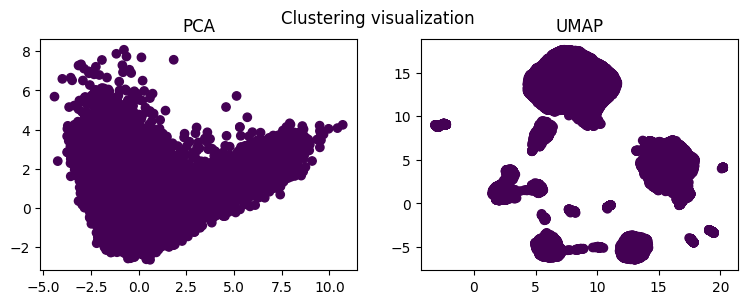

In [10]:
clustering_visualizer = ClusteringVisualizer(X)
clustering_visualizer.visualize()

## Komentarz

W przypadku PCA nie można jednoznacznie wskazać wyodrębnionych klastrów wizualizacji, ale w przypadku UMAP jest znacznie lepiej. Redukcja nieliniowa w UMAP przyczyniła się do uzyskania lepszej wizualizacji klastrów.

Teraz przeanalizujemy nasz zbiór. Posłużą nam do tego poniżej zdefiniowane klasy `KMeansAnalzyer`, `DBSCANAnalyzer` i `HDBSCANAnalyzer`. Metoda `.analyze_clustering()` dla każdego klastra:
1. Wypisuje liczbę klastrów, oraz informację o szumie (dla DBSCAN i HDBSCAN).
2. Wypisuje wartość metryki [Calinski-Harabasz index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html), jeżeli liczba klastrów to co najmniej 2. Dla DBSCAN i HDBSCAN uwzględniamy tylko punkty z klastrów, ignorując szum.
2. Rysuje wykres klastrów po redukcji z PCA oraz UMAP.
3. Tworzy [wykres radowy (radar chart)](https://plotly.com/python/radar-chart/). Pozwala on wygodnie porównać wartości średnie dla poszczególnych cech.
4. Wypisuje piosenki i artystów reprezentujące klaster:
   - dla k-means jest to 10 punktów najbliższych do centroidu
   - dla DBSCAN wybieramy heurystycznie 10 punktów najbliższych do centroidu
   - dla HDBSCAN wybieramy punkty o najwyższym prawdopodobieństwie (nie używamy exemplars, bo jest to bardzo wolne [i mało wygodne](https://github.com/scikit-learn-contrib/hdbscan/issues/304))
5. Wypisuje 10 najczęstszych gatunków muzycznych w klastrze.

Dla DBSCAN i HDBSCAN, które same wykrywają liczbę klastrów i może być ich bardzo dużo, analizowane jest tylko:
- max 10 największych klastrów
- tylko te, które mają co najmniej 100 próbek

Na początek potraktujemy cały nasz zbiór jako jeden wielki klaster dla algorytmu k-means i popatrzymy, co tam się dzieje.

In [11]:
import itertools
from abc import ABC, abstractmethod
from collections import Counter

import plotly.graph_objects as go

from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import minmax_scale


class ClusteringAnalyzer(ABC):
    def __init__(
        self, df_songs_info: pd.DataFrame, clustering_visualizer: ClusteringVisualizer
    ):
        self.df_songs_info = df_songs_info
        self.clustering_visualizer = clustering_visualizer

    @abstractmethod
    def analyze_clustering(self, X: pd.DataFrame, clustering) -> None:
        raise NotImplementedError()

    def _get_top_clusters_labels(self, labels: np.ndarray) -> np.ndarray:
        labels = labels[labels != -1]
        label_counts = pd.Series(labels).value_counts()
        label_counts = label_counts[label_counts >= 100]
        top_labels = label_counts.index[:10].values
        return top_labels

    def _create_radar_chart(self, X: pd.DataFrame, label: int) -> None:
        fig = go.Figure()
        vals = minmax_scale(X).mean()
        fig.add_trace(go.Scatterpolar(r=vals, theta=X.columns, fill="toself"))
        fig.update_layout(title_text=f"Cluster {label}", title_x=0.5)
        fig.update_polars(radialaxis=dict(range=[0, 1]))
        fig.show()

    def _get_central_songs(
        self, X: pd.DataFrame, cluster_songs_info: pd.DataFrame, prototype: np.ndarray
    ) -> None:
        n_neighbors = min(10, len(X))
        nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
        nn.fit(X.values)
        _, nn_idxs = nn.kneighbors(prototype)
        nn_idxs = nn_idxs.ravel()
        nn_songs_info = cluster_songs_info.iloc[nn_idxs]
        nn_songs_info = nn_songs_info.drop(columns="genres")
        nn_songs_info.columns = ["Track", "Artist"]
        nn_songs_info = nn_songs_info.reset_index(drop=True)
        display(nn_songs_info)

    def _get_cluster_top_genres(
        self,
        cluster_songs_info: pd.DataFrame,
    ) -> None:
        genres = cluster_songs_info["genres"].values
        genres = [ast.literal_eval(x) for x in genres]
        genres = Counter(itertools.chain(*genres))
        top_genres = genres.most_common(10)
        top_genres = [name for name, count in top_genres]
        print("Top 10 genres in the cluster:", top_genres)


class KMeansAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: KMeans) -> None:
        labels = clustering.labels_
        centroids = clustering.cluster_centers_

        print(f"Number of clusters: {max(labels) + 1}")

        if labels.max() >= 2:
            ch_index = calinski_harabasz_score(X, labels)
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in range(0, max(labels) + 1):
            X_cluster = X[labels == label]
            cluster_songs_info = self.df_songs_info[labels == label]
            centroid = centroids[label].reshape((1, -1))

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_central_songs(X_cluster, cluster_songs_info, centroid)
            self._get_cluster_top_genres(cluster_songs_info)


class DBSCANAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: KMeans) -> None:
        labels = clustering.labels_

        noise_num = (labels == -1).sum()
        noise_perc = noise_num / len(X)

        print(f"Number of clusters: {max(labels) + 1}")
        print(f"Percentage of noise points: {100 * noise_perc:.2f}%")

        if labels.max() >= 2:
            X_non_noise = X[labels != -1]
            labels_non_noise = labels[labels != -1]
            ch_index = calinski_harabasz_score(
                X_non_noise,
                labels_non_noise,
            )
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in self._get_top_clusters_labels(labels):
            X_cluster = X[labels == label]
            cluster_songs_info = self.df_songs_info[labels == label]
            centroid = self._get_cluster_centroid(X_cluster)

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_central_songs(X_cluster, cluster_songs_info, centroid)
            self._get_cluster_top_genres(cluster_songs_info)

    def _get_cluster_centroid(self, X_cluster: pd.DataFrame) -> np.ndarray:
        centroid = np.mean(X_cluster.values, axis=0)
        return np.array(centroid).reshape((1, -1))


class HDBSCANAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: HDBSCAN) -> None:
        labels = clustering.labels_
        probas = clustering.probabilities_

        noise_num = (labels == -1).sum()
        noise_perc = noise_num / len(X)

        print(f"Number of clusters: {max(labels) + 1}")
        print(f"Percentage of noise points: {100 * noise_perc:.2f}%")

        if labels.max() >= 2:
            X_non_noise = X[labels != -1]
            labels_non_noise = labels[labels != -1]
            ch_index = calinski_harabasz_score(
                X_non_noise,
                labels_non_noise,
            )
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in self._get_top_clusters_labels(labels):
            X_cluster = X[labels == label]
            cluster_songs_info = self.df_songs_info[labels == label]
            cluster_probas = probas[labels == label]

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_most_probable_songs(cluster_songs_info, cluster_probas)
            self._get_cluster_top_genres(cluster_songs_info)

    def _get_most_probable_songs(
        self, cluster_songs_info: pd.DataFrame, cluster_probas: np.ndarray
    ) -> None:
        top_10_indexes = np.argpartition(cluster_probas, -10)[-10:]
        nn_songs_info = cluster_songs_info.iloc[top_10_indexes]
        nn_songs_info = nn_songs_info.drop(columns="genres")
        nn_songs_info.columns = ["Track", "Artist"]
        nn_songs_info = nn_songs_info.reset_index(drop=True)
        display(nn_songs_info)

Number of clusters: 1


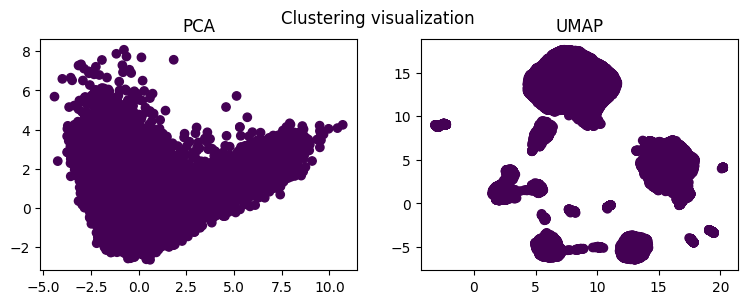

Cluster 0 size: 76040


,Track,Artist
0,H.I.E.L.O.,Duki
1,Confiado & Tranquilo,Paulo Londra
2,Rüyalarda Buruşmuşum,Adamlar
3,Lay It All on Me (feat. Ed Sheeran),Rudimental
4,Regenbogenfarben,Kerstin Ott
5,Problèmes d'adultes,Sexion d'Assaut
6,Je me dis que toi aussi,Boulevard des Airs
7,Nena Maldición (feat. Lenny Tavárez),Paulo Londra
8,Amame,Alexandre Pires
9,Frank Sinatra,Cake


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'latin', 'classic rock', 'latin pop', 'rap', 'mellow gold', 'soft rock', 'hip hop']


In [12]:
from sklearn.cluster import KMeans


clustering = KMeans(n_clusters=1, n_init="auto", random_state=0)
clustering.fit(X)

kmeans_analyzer = KMeansAnalyzer(df_songs_info, clustering_visualizer)
kmeans_analyzer.analyze_clustering(X, clustering)

Wygląda na to, że najpopularniejsze są pop i rock, a najbardziej "typowe" piosenki też należą do takiej grupy. Ogół piosenek ma dość dużą głośność, dużą dynamikę (wysokie time signature - "how many beats are in each bar") i są pozytywne (valence - "tracks with high valence sound more positive"). Zasadniczo jest to zgodne z intuicją. Ciekawe jednak, co będzie, jak wybierzemy więcej klastrów.

**Zadanie 3 (1.5 punktu)**

1. Wytrenuj k-means dla 3 klastrów.
2. Zwizualizuj wyniki za pomocą PCA i UMAP. Jako kolor punktów (np. parametr `c` w `plt.scatter()`) przekaż numery klastrów dla punktów.
3. Dokonaj opisu i analizy wynikowych klastrów, na przykład:
   - czy reprezentują jakieś konkretne grupy muzyczne?
   - na ile "konkretne", sensowne są klastry?
   - czy jest widoczna separacja klastrów, czy różnią się od siebie?
4. Dokonaj tuningu liczby klastrów:
   - sprawdź wartości z zakresu [5, 20] - w końcu wiemy, że gatunków jest sporo, i klastrów powinno też być więcej
   - dla każdej wartości sprawdź wartość metryki [Calinski-Harabasz index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html)
   - przedstaw wykres liniowy (line plot) wartości metryki
   - wybierz model o najwyższej wartości metryki
   - zwizualizuj wyniki z pomocą PCA i UMAP
   - dokonaj interpretacji jego klastrów
   - skomentuj:
     - czy klastry są faktycznie lepiej interpretowalne po tuningu?
     - czy wysokość CH-index faktycznie odpowiada jakości klasteryzacji?


Number of clusters: 3
CH-index value: 9449.70


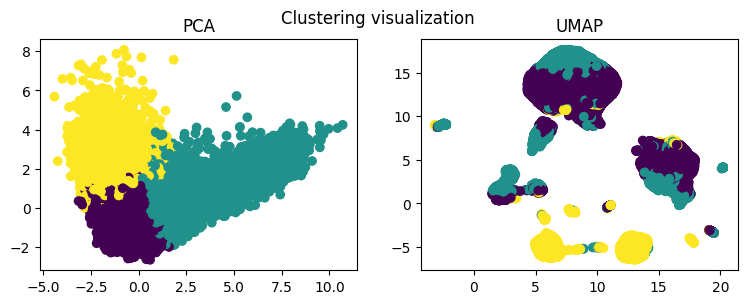

Cluster 0 size: 47478


,Track,Artist
0,Guerrera,DELLAFUENTE
1,Ojos Así,Shakira
2,Seviyorum Sevmiyorum,Nil Karaibrahimgil
3,Meltinpot,Gazzelle
4,Lay It All on Me (feat. Ed Sheeran),Rudimental
5,Small Town USA,Justin Moore
6,Ni Mandándote A Hacer,Calibre 50
7,Girl At Home,Taylor Swift
8,Suspicious Minds,Fine Young Cannibals
9,Painkiller,Ruel


Top 10 genres in the cluster: ['rock', 'pop', 'latin', 'dance pop', 'latin pop', 'classic rock', 'regional mexican', 'album rock', 'soft rock', 'mellow gold']
Cluster 1 size: 16222


,Track,Artist
0,A fuego - Bizarrap Remix,DrefQuila
1,Stay Alive,José González
2,Ol' 55,Tom Waits
3,Smoke on the Water,The Cooltrane Quartet
4,Kto powie mi jak,Kwiat Jabłoni
5,Raatein,Jasleen Royal
6,Find Yourself,Brad Paisley
7,Basta Ya Mi Amor,Agua Marina
8,Even the Nights Are Better,Air Supply
9,La Danza de las Libélulas (Con Mon Laferte),Manuel García


Top 10 genres in the cluster: ['rock', 'adult standards', 'classic rock', 'mellow gold', 'pop', 'soft rock', 'album rock', 'folk rock', 'latin pop', 'latin']
Cluster 2 size: 12340


,Track,Artist
0,Dangerous (feat. YG),The Neighbourhood
1,Dándole,Arte Elegante
2,7 sur 7,Koba LaD
3,Primo,RAF Camora
4,Van Damme,SDM
5,No Stress,Kekra
6,Vertigini,Tedua
7,Paper Route,Hooligan Hefs
8,Le regard des gens,Nekfeu
9,Zły,Szpaku


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'trap', 'pop urbaine', 'french hip hop', 'pop', 'southern hip hop', 'dance pop']


In [13]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans.fit(X)
kmeans_analyzer = KMeansAnalyzer(df_songs_info, clustering_visualizer)
kmeans_analyzer.analyze_clustering(X, kmeans)

## Komentarz

W wynikach klastryzacji jest widoczny dosyć wyraźny podział międzygatunkowy, z którego można wyróżnić klastry reprezentujące gatunki muzyczne takie jak "pop", "rock" i "hip hop". Klastry różnią się od siebie i wizualnie można zaobserwować, że różnice między nimi są liniowe

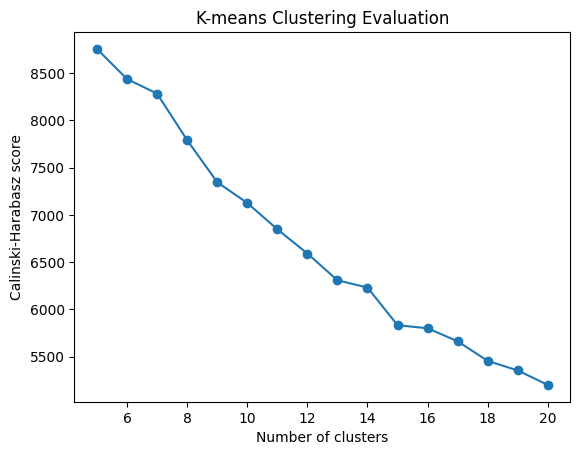

Best number of clusters: 5
Number of clusters: 5
CH-index value: 8756.86


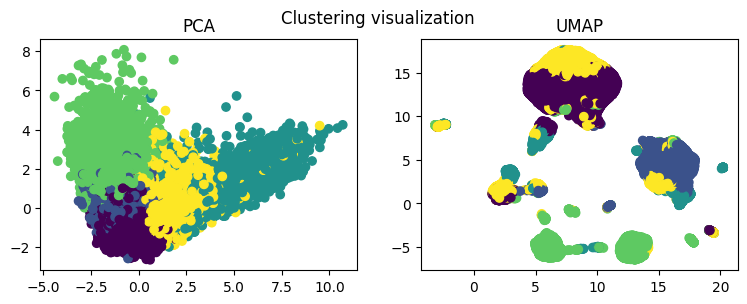

Cluster 0 size: 28403


,Track,Artist
0,Guerrera,DELLAFUENTE
1,Ojos Así,Shakira
2,Meltinpot,Gazzelle
3,Bagatelle,Pinguini Tattici Nucleari
4,Ni Mandándote A Hacer,Calibre 50
5,Small Town USA,Justin Moore
6,Podría Ser Peor,La Casa Azul
7,Lay It All on Me (feat. Ed Sheeran),Rudimental
8,Painkiller,Ruel
9,Girl At Home,Taylor Swift


Top 10 genres in the cluster: ['rock', 'pop', 'latin', 'dance pop', 'classic rock', 'regional mexican', 'latin pop', 'pop rock', 'mellow gold', 'album rock']
Cluster 1 size: 18305


,Track,Artist
0,Elevator (feat. Timbaland),Flo Rida
1,Туманы,Max Barskih
2,Secret Door,Arctic Monkeys
3,Quién eres tú (feat. Trey Songz),María José
4,Haus am See,Peter Fox
5,Te Necesito,Bhavi
6,Sıfır Tolerans,Hadise
7,Trivia 承 : Love,BTS
8,Real Life,Duke Dumont
9,Comes and Goes 와리가리,HYUKOH


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'latin', 'latin pop', 'tropical', 'trap latino', 'classic rock', 'rock en espanol', 'desi pop']
Cluster 2 size: 3556


,Track,Artist
0,Beyond the Sea,Richard Clayderman
1,Burn One Down,Ben Harper
2,Kid A,Radiohead
3,How Deep Is Your Love,Richard Clayderman
4,Exchange,Massive Attack
5,Tender love,Mounika.
6,With Or Without You,2CELLOS
7,Heimta Thurs,Wardruna
8,blown a wish,my bloody valentine
9,The Great Gig In The Sky - 2011 Remastered Ver...,Pink Floyd


Top 10 genres in the cluster: ['rock', 'soundtrack', 'classical', 'alternative rock', 'art rock', 'electronica', 'classic rock', 'album rock', 'permanent wave', 'alternative metal']
Cluster 3 size: 11862


,Track,Artist
0,Dándole,Arte Elegante
1,Dangerous (feat. YG),The Neighbourhood
2,Primo,RAF Camora
3,7 sur 7,Koba LaD
4,Vertigini,Tedua
5,Broken Clocks,SZA
6,Le regard des gens,Nekfeu
7,Van Damme,SDM
8,Paper Route,Hooligan Hefs
9,Zły,Szpaku


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'trap', 'pop urbaine', 'french hip hop', 'pop', 'southern hip hop', 'dance pop']
Cluster 4 size: 13914


,Track,Artist
0,İki Gözümün Çiçeği,Manuş Baba
1,Chachachá,Jósean Log
2,Ol' 55,Tom Waits
3,Aaftaab,The Local Train
4,Agárrate a mí María (feat. Antonio Vega),Los Secretos
5,How Deep Is Your Love,Take That
6,Isn't It Romantic,Rod Stewart
7,Even the Nights Are Better,Air Supply
8,Evidencias,Ana Gabriel
9,Ebrio De Amor,Ezequiel Peña


Top 10 genres in the cluster: ['adult standards', 'rock', 'mellow gold', 'pop', 'classic rock', 'soft rock', 'latin pop', 'latin', 'folk rock', 'ranchera']


In [16]:
clusters_range = range(5, 21)
ch_scores = []

for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    kmeans.fit(X)
    labels = kmeans.labels_
    ch_index = calinski_harabasz_score(X, labels)
    ch_scores.append(ch_index)

plt.plot(clusters_range, ch_scores, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Calinski-Harabasz score")
plt.title("K-means Clustering Evaluation")
plt.show()

best_num_clusters = ch_scores.index(max(ch_scores)) + 5
print(f"Best number of clusters: {best_num_clusters}")

best_kmeans = KMeans(n_clusters=best_num_clusters, random_state=0, n_init=10)
best_kmeans.fit(X)

kmeans_analyzer = KMeansAnalyzer(df_songs_info, clustering_visualizer)
kmeans_analyzer.analyze_clustering(X, best_kmeans)

## Komentarz

Po dostrojeniu algorytmu klastryzacji można zaobserwować, że klastry stają się bardziej interpretowalne. W tym przypadku po tuningu otrzymujemy jeden nowy klaster, co czyni zbiór bardziej precyzyjnym i lepiej interpretowalnym. Wyższa wartość CH-index faktycznie koreluje z lepszą jakością klasteryzacji. Można zauważyć, że najlepszy model, który osiąga najwyższy CH-index, przewyższa inne modele, a dalszy spadek wartości CH-index jest prawie liniowy. Wniosek jest taki, że wysokość CH-index ma wpływ na jakość klasteryzacji, a wyższa wartość CH-index wskazuje na lepszą separację klastrów.

Problem z k-means jest taki, że wykrywa tylko klastry sferyczne. W przypadku zbiorów, w których klastry mogą być mocno wymieszane, będzie to szczególnym problemem. Tak może być tutaj - w końcu mamy co najmniej kilka podgatunków rocka i popu, które są zbliżone do siebie. Mamy też dość egzotyczne podgatunki takie jak "art rock" czy "rock en espanol", które być może są nieliczne i stanowią de facto szum.

Do takich sytuacji doskonale nadaje się DBSCAN. Ma co prawda większą złożoność, ale dla danych tego rozmiaru jest to jeszcze akceptowalne. Sprawdźmy, jak działa dla domyślnych hiperparametrów - epsilon 0.5 i min_samples 5.

Number of clusters: 267
Percentage of noise points: 92.80%
CH-index value: 32.46


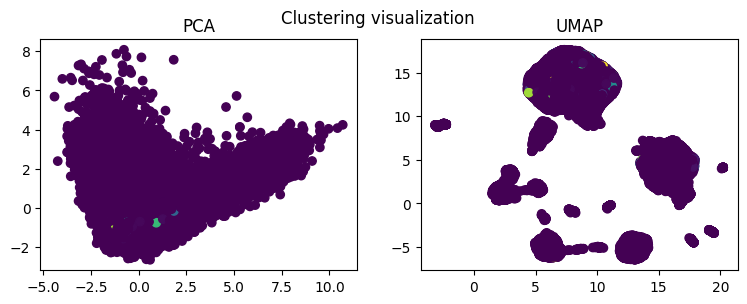

Cluster 4 size: 2961


,Track,Artist
0,Love Today,MIKA
1,Mirala Miralo,Alejandra Guzman
2,"The Karma Theme - Telugu (From ""U Turn"")",Anirudh Ravichander
3,"Mírala, Míralo - En Vivo",Alejandra Guzman
4,CROWN,TOMORROW X TOGETHER
5,Baila Morena - New Spanish Version,Zucchero
6,No Such Thing,John Mayer
7,Walau Habis Terang,Noah
8,New Romantics,Taylor Swift
9,Bailarina,Maldita Nerea


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'pop rock', 'post-teen pop', 'latin', 'latin pop', 'modern rock', 'classic rock', 'rock en espanol']
Cluster 21 size: 209


,Track,Artist
0,YO VISTO ASÍ,Bad Bunny
1,"Auf das, was da noch kommt",Max Giesinger
2,Girl's Not Grey,AFI
3,Ahora Lloras Tú (feat. CNCO),Ana Mena
4,IL MIO AMICO (feat. Fabri Fibra),Madame
5,너라고 It's You,SUPER JUNIOR
6,On The Beach,Jubël
7,Peligrosa,J Balvin
8,Berre i natt,Rotlaus
9,10 Months,ENHYPEN


Top 10 genres in the cluster: ['dance pop', 'pop', 'post-teen pop', 'latin', 'rock', 'edm', 'latin pop', 'pop dance', 'turkish pop', 'modern rock']
Cluster 1 size: 108


,Track,Artist
0,I Won't Let Go,Rascal Flatts
1,大眠,Cyndi Wang
2,Beautiful In White,Matt Johnson
3,If I Die Young (Glee Cast Version),Glee Cast
4,I See A Darkness,Johnny Cash
5,最佳損友 - Single Version,Eason Chan
6,Tak Ingin Sendiri,Felix Irwan
7,Un giorno credi,Edoardo Bennato
8,The Gift (feat. Collin Raye & Susan Ashton),Jim Brickman
9,Untuk Apa,Maudy Ayunda


Top 10 genres in the cluster: ['latin', 'latin pop', 'latin arena pop', 'opm', 'pop', 'indonesian pop', 'viral pop', 'mandopop', 'tropical', 'mexican pop']


In [17]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Mamy niesamowicie dużo klastrów oraz szumu - niedobrze! Oznacza to, że zbyt ciężko jest "dotrzeć" do kolejnych punktów, żeby stworzyć klastry. Mogą być tego dwie przyczyny:
- zbyt mały promień epsilon
- zbyt duże min_samples

Biorąc pod uwagę, że minimalna liczba próbek to zaledwie 5, to to drugie nie występuje. Musimy zatem zwiększyć promień. Ale jak, skoro nie znamy jednostek?

Dobór hiperparametrów w DBSCAN dobrze opisuje [ten post](http://www.sefidian.com/2022/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/), który zgadza się zresztą z "Data Clustering" Charu C. Aggarwala.

Wartość min_samples można przyjąć z grubsza (rule-of-thumb) jako liczbę wymiarów razy 2. Bierze to poprawkę na rzadkość przestrzeni, i generalnie jest dobrą wartością wyjściową. Jeżeli mamy dużo szumu, to można próbować więcej.

Przy stałym min_samples heurystyka do wyboru epsilon wygląda następująco. Obliczamy rozkład odległości do k najbliższych sąsiadów, przyjmując k = min_samples, a następnie przedstawiamy to na wykresie. Typowo będzie miał kształt z grubsza zbliżony do litery L (lub odwróconego L), i dobra wartość epsilon jest na punkcie przegięcia tego wykresu, tzw. elbow / knee.

**Zadanie 4 (1.5 punktu)**

Stwórz wykres odległości do najbliższych sąsiadów, przyjmując liczbę najbliższych sąsiadów równą 2 razy liczba cech. Może się przydać [ten tutorial](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd).

Odczytaj z wykresu wartość punktu przegięcia. Czy jest to łatwe? Czy jesteś w stanie ją wyznaczyć dokładnie?

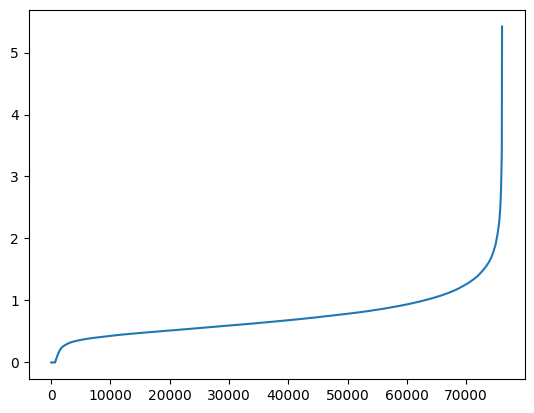

In [19]:
neighbors = NearestNeighbors(n_neighbors=X.shape[1] * 2)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.show()

## Komentarz

Odczytanie dokładnej wartości punktu przegięcia z wykresu może być trudne. Szacuję, że wartość punktu przegięcia wynosi około 75000. Jednak nie jestem w stanie dokładnie wyznaczyć tej wartości, a jedynie szacować ją.

Taka heurystyczna metoda jest wykorzystywana w wielu przypadkach doboru hiperparametrów w klasteryzacji. Zasadnicza idea jest taka, że punkt przegięcia odpowiada momentowi, gdzie dane zaczynają wyraźnie rozróżniać się od siebie i tworzyć wyraźne grupy. Jest to proste i szybkie, ale jest dość nieprecyzyjne w porównaniu do innych metod (jeżeli w ogóle istnieją dla danego zadania!). Jeżeli chcemy zrobić walidację skrośną, korzystając z jakiejś metryki, to taki wykres daje nam sensowny punkt wyjścia do zakresu hiperparametru.

Warto też pamiętać, że klasteryzacja to proces z natury interaktywny. Takie wykresy są ważne, bo zwiększają naszą intuicję, ale np. dokładne dobranie wartości jest typowo robione ręcznie.

**Zadanie 5 (1.5 punktu)**

Wytrenuj DBSCAN z promieniem epsilon wyznaczonym z wykresu i min_samples równym 2 razy liczbie cech. W razie potrzeby zmniejsz lub zwiększ epsilon, aby uzyskać wyniki, które wydają się sensowne (liczba klastrów, procent szumu, CH-index).

Dokonaj analizy wyjściowych klastrów. Czy finalna ich liczba oraz procent szumu są sensowne? Czy klastry są lepiej widoczne, lub lepiej interpretowalne, niż w przypadku k-means?

Number of clusters: 0
Percentage of noise points: 100.00%


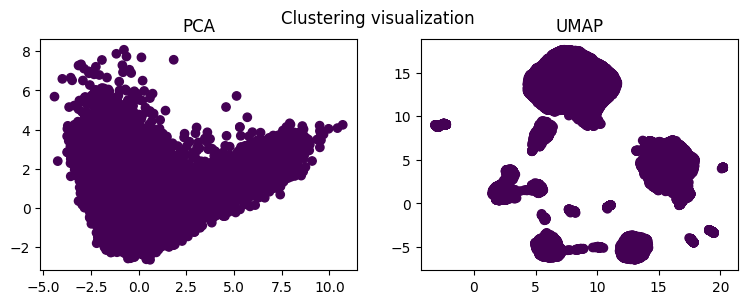

In [21]:
clustering = DBSCAN(eps=0.3, min_samples=X.shape[1] * 2, n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Number of clusters: 0
Percentage of noise points: 100.00%


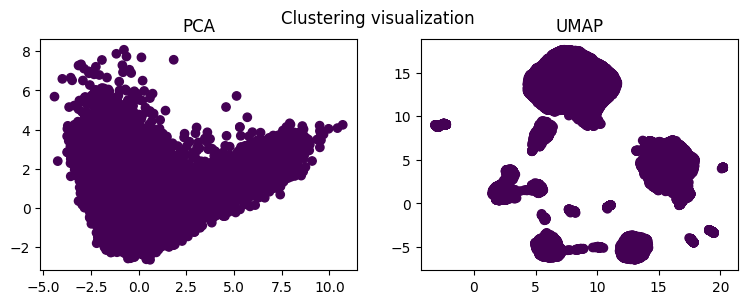

In [20]:
clustering = DBSCAN(eps=0.4, min_samples=X.shape[1] * 2, n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Number of clusters: 1
Percentage of noise points: 99.97%


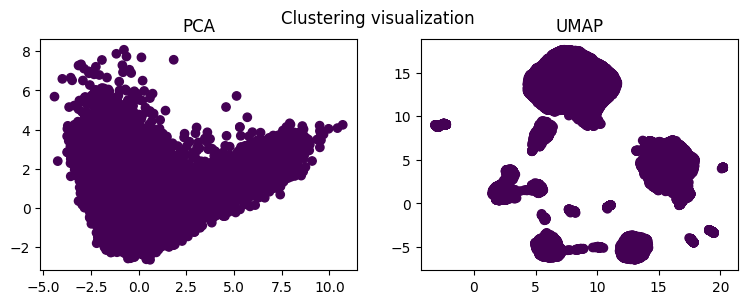

In [22]:
clustering = DBSCAN(eps=0.5, min_samples=X.shape[1] * 2, n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Number of clusters: 8
Percentage of noise points: 97.78%
CH-index value: 221.39


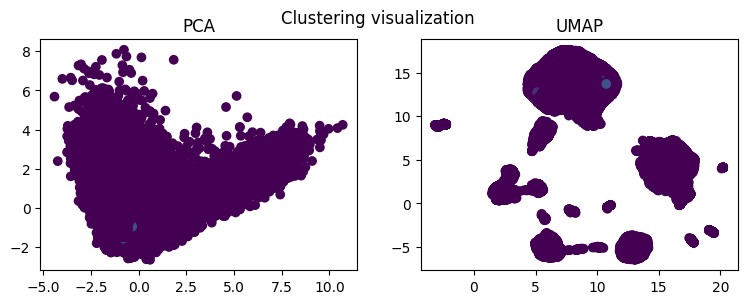

Cluster 1 size: 898


,Track,Artist
0,Harika,Ebru Gündeş
1,Menneskeforbruger,Fyr Og Flamme
2,We Found Love,Rihanna
3,Al Fin Sucede,Gustavo Cerati
4,Dirt,Florida Georgia Line
5,Bailemos,Dani Fernández
6,Before I Fall To Pieces,Razorlight
7,SHY (feat. Brayton Bowman),The Magician
8,No Creo,Shakira
9,Back Against the Wall,Cage The Elephant


Top 10 genres in the cluster: ['dance pop', 'pop', 'rock', 'pop rock', 'post-teen pop', 'latin', 'latin pop', 'modern rock', 'pop dance', 'permanent wave']
Cluster 0 size: 671


,Track,Artist
0,Trouble Is a Friend,Lenka
1,We R Who We R,Kesha
2,Opportunities (Let's Make Lots of Money) - 200...,Pet Shop Boys
3,Nån annan nu,Molly Sandén
4,When It Rains,Paramore
5,Florentinos y Ferminas,Los Caligaris
6,Espectacular,Fangoria
7,Actos De Un Tonto,Conjunto Primavera
8,Heartache On The Dance Floor,Jon Pardi
9,I'm Born To Run,American Authors


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'pop rock', 'latin', 'latin pop', 'classic rock', 'permanent wave', 'contemporary country']


In [23]:
clustering = DBSCAN(eps=0.6, min_samples=X.shape[1] * 2, n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Number of clusters: 11
Percentage of noise points: 86.78%
CH-index value: 321.42


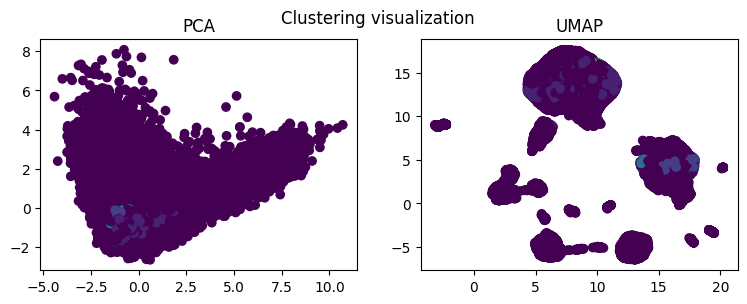

Cluster 0 size: 7923


,Track,Artist
0,Ni Mandándote A Hacer,Calibre 50
1,Regenbogenfarben,Kerstin Ott
2,Morir Tres Veces,Mœnia
3,Fallin' For You,Colbie Caillat
4,"Gone, Gone, Gone",Phillip Phillips
5,Lay It On Me,Vance Joy
6,Girl At Home,Taylor Swift
7,Love Today,MIKA
8,Not Alone,Linkin Park
9,CROWN,TOMORROW X TOGETHER


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'latin', 'latin pop', 'post-teen pop', 'pop rock', 'modern rock', 'rock en espanol', 'classic rock']
Cluster 1 size: 1657


,Track,Artist
0,Ocean Drive,Duke Dumont
1,Join Me - Razorblade Mix,HIM
2,Каждый раз,Monetochka
3,Stop! Dimentica,Tiziano Ferro
4,Cámara De Faltas,Enjambre
5,Real Life,Duke Dumont
6,Comes and Goes 와리가리,HYUKOH
7,Can't Feel My Face,The Weeknd
8,Berre i natt,Rotlaus
9,"Auf das, was da noch kommt",Max Giesinger


Top 10 genres in the cluster: ['dance pop', 'pop', 'latin', 'post-teen pop', 'rock', 'latin pop', 'pop dance', 'edm', 'tropical house', 'modern rock']
Cluster 3 size: 281


,Track,Artist
0,Disfruto - Audioiko Remix,Carla Morrison
1,7 Things - Single Version,Miley Cyrus
2,Want to Want Me,Jason Derulo
3,7 Things,Miley Cyrus
4,Cemetery Drive,My Chemical Romance
5,Why Worry,Set It Off
6,Straight Through My Heart,Backstreet Boys
7,Little Bit of Love,Tom Grennan
8,Red,Taylor Swift
9,We Drink Your Blood,Powerwolf


Top 10 genres in the cluster: ['dance pop', 'pop', 'post-teen pop', 'latin', 'pop dance', 'pop rock', 'latin pop', 'rock', 'edm', 'tropical house']


In [24]:
clustering = DBSCAN(eps=0.7, min_samples=X.shape[1] * 2, n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Number of clusters: 4
Percentage of noise points: 70.52%
CH-index value: 1666.47


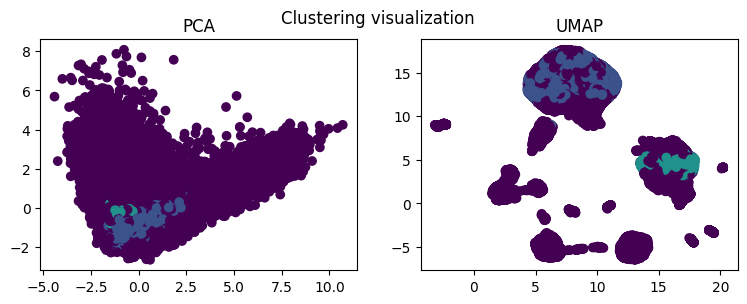

Cluster 0 size: 17096


,Track,Artist
0,Regenbogenfarben,Kerstin Ott
1,Morir Tres Veces,Mœnia
2,Ni Mandándote A Hacer,Calibre 50
3,Girl At Home,Taylor Swift
4,"Gone, Gone, Gone",Phillip Phillips
5,ลึก ลึก (Deep),SCRUBB
6,Fallin' For You,Colbie Caillat
7,Pobre soñador,El Tri
8,Not Alone,Linkin Park
9,Lay It All on Me (feat. Ed Sheeran),Rudimental


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'latin', 'latin pop', 'pop rock', 'post-teen pop', 'classic rock', 'soft rock', 'mellow gold']
Cluster 1 size: 5276


,Track,Artist
0,Comes and Goes 와리가리,HYUKOH
1,"Auf das, was da noch kommt",Max Giesinger
2,Stop! Dimentica,Tiziano Ferro
3,Zusammen feat. Clueso,Die Fantastischen Vier
4,Berre i natt,Rotlaus
5,Real Life,Duke Dumont
6,Cámara De Faltas,Enjambre
7,Sugar (feat. Francesco Yates),Robin Schulz
8,We Are One (Ole Ola) [The Official 2014 FIFA W...,Pitbull
9,Keep Myself Alive,Get Scared


Top 10 genres in the cluster: ['dance pop', 'pop', 'latin', 'rock', 'post-teen pop', 'latin pop', 'pop dance', 'edm', 'tropical', 'tropical house']


In [25]:
clustering = DBSCAN(eps=0.8, min_samples=X.shape[1] * 2, n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Number of clusters: 11
Percentage of noise points: 56.32%
CH-index value: 880.30


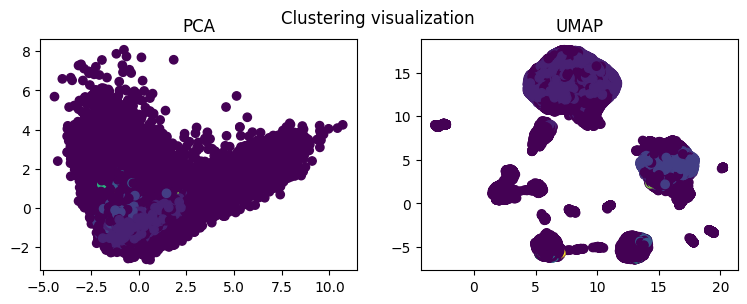

Cluster 0 size: 23076


,Track,Artist
0,Regenbogenfarben,Kerstin Ott
1,Morir Tres Veces,Mœnia
2,Girl At Home,Taylor Swift
3,ลึก ลึก (Deep),SCRUBB
4,Ni Mandándote A Hacer,Calibre 50
5,H.I.E.L.O.,Duki
6,Pobre soñador,El Tri
7,Amame,Alexandre Pires
8,Fallin' For You,Colbie Caillat
9,Lay It All on Me (feat. Ed Sheeran),Rudimental


Top 10 genres in the cluster: ['rock', 'pop', 'latin', 'dance pop', 'latin pop', 'pop rock', 'classic rock', 'post-teen pop', 'mellow gold', 'soft rock']
Cluster 1 size: 9382


,Track,Artist
0,Comes and Goes 와리가리,HYUKOH
1,Real Life,Duke Dumont
2,Stop! Dimentica,Tiziano Ferro
3,Divane,Yaşar
4,Туманы,Max Barskih
5,"Auf das, was da noch kommt",Max Giesinger
6,Zusammen feat. Clueso,Die Fantastischen Vier
7,OK,Robin Schulz
8,Live In Life,The Rubens
9,Helwa,Gilli


Top 10 genres in the cluster: ['pop', 'dance pop', 'latin', 'rock', 'latin pop', 'post-teen pop', 'tropical', 'trap latino', 'rock en espanol', 'turkish pop']
Cluster 2 size: 351


,Track,Artist
0,EWA,Bizzey
1,1980,Rehab
2,Vakantie,Lil Kleine
3,Clic Clac Bang Bang,Jok'air
4,Prospect (ft. Lil Baby),iann dior
5,"thank u, next",Ariana Grande
6,Flyte,Pablo Chill-E
7,Мне лень,T-Fest
8,Nefret,Ezhel
9,ZIDANE,SQWOZ BAB


Top 10 genres in the cluster: ['rap', 'pop rap', 'pop', 'hip hop', 'trap', 'dance pop', 'pop urbaine', 'french hip hop', 'southern hip hop', 'italian hip hop']
Cluster 3 size: 135


,Track,Artist
0,Зашей,GONE.Fludd
1,Yemin Olsun,Ufo361
2,SLIME (feat. Rondodasosa),Lazza
3,Vivere (feat. Izi),Mecna
4,Retro (Rough),Childish Gambino
5,772 Love,YNW Melly
6,Brutti Sogni,Sfera Ebbasta
7,Tu sais pas,PNL
8,Ghost Town,Adam Lambert
9,Mercedes Nero,Sfera Ebbasta


Top 10 genres in the cluster: ['italian hip hop', 'rap', 'trap italiana', 'french hip hop', 'pop urbaine', 'german hip hop', 'hip hop', 'pop rap', 'trap', 'dance pop']


In [26]:
clustering = DBSCAN(eps=0.9, min_samples=X.shape[1] * 2, n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Number of clusters: 9
Percentage of noise points: 44.50%
CH-index value: 1716.17


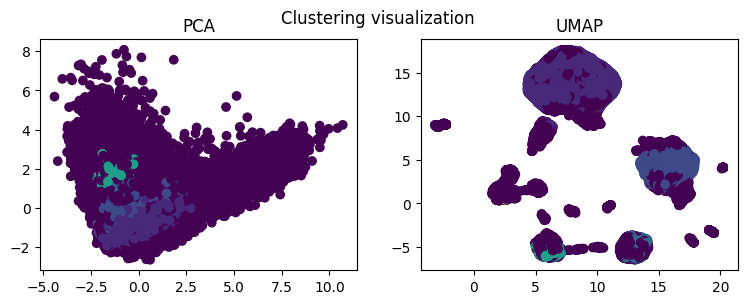

Cluster 0 size: 27081


,Track,Artist
0,Regenbogenfarben,Kerstin Ott
1,Morir Tres Veces,Mœnia
2,Girl At Home,Taylor Swift
3,ลึก ลึก (Deep),SCRUBB
4,H.I.E.L.O.,Duki
5,Amame,Alexandre Pires
6,Ni Mandándote A Hacer,Calibre 50
7,Jab Tak (Redux),Armaan Malik
8,Pobre soñador,El Tri
9,Lay It All on Me (feat. Ed Sheeran),Rudimental


Top 10 genres in the cluster: ['rock', 'pop', 'latin', 'dance pop', 'latin pop', 'classic rock', 'mellow gold', 'soft rock', 'pop rock', 'post-teen pop']
Cluster 1 size: 12306


,Track,Artist
0,Comes and Goes 와리가리,HYUKOH
1,Туманы,Max Barskih
2,Real Life,Duke Dumont
3,Divane,Yaşar
4,Trivia 承 : Love,BTS
5,Spinning Around,Kylie Minogue
6,Maintenant - Version radio,Les Enfoirés
7,Helwa,Gilli
8,Stop! Dimentica,Tiziano Ferro
9,Elevator (feat. Timbaland),Flo Rida


Top 10 genres in the cluster: ['pop', 'dance pop', 'latin', 'rock', 'latin pop', 'post-teen pop', 'tropical', 'turkish pop', 'trap latino', 'rock en espanol']
Cluster 2 size: 1485


,Track,Artist
0,skittles,Karpe
1,Fuori E Dentro (feat. tha Supreme),Gemitaiz
2,242,Ati242
3,Crazy = Genius,Panic! At The Disco
4,ซุปเปอร์ไซย่า,UrboyTJ
5,Tattoos Together,Lauv
6,FML,Arizona Zervas
7,Nefret,Ezhel
8,occh1 purpl3 - feat. Marracash,tha Supreme
9,1980,Rehab


Top 10 genres in the cluster: ['rap', 'pop rap', 'hip hop', 'pop', 'trap', 'dance pop', 'southern hip hop', 'gangster rap', 'pop urbaine', 'french hip hop']
Cluster 4 size: 1155


,Track,Artist
0,Good Weed Bad B*tch,K CAMP
1,Ballin,Luciano
2,J'ai pas dormi de la nuit,Djadja & Dinaz
3,Brutti Sogni,Sfera Ebbasta
4,Allah'ından Bul,Ezhel
5,Toto (feat. RAF Camora),Noizy
6,Cut Me Off (feat. D-Block Europe),Yxng Bane
7,nasty,Ariana Grande
8,Mademoiselle,Sfera Ebbasta
9,Moulaga,Heuss L'enfoiré


Top 10 genres in the cluster: ['rap', 'pop urbaine', 'french hip hop', 'pop rap', 'rap francais', 'pop', 'hip hop', 'dance pop', 'italian hip hop', 'trap']


In [27]:
clustering = DBSCAN(eps=1.0, min_samples=X.shape[1] * 2, n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Number of clusters: 11
Percentage of noise points: 34.07%
CH-index value: 1988.22


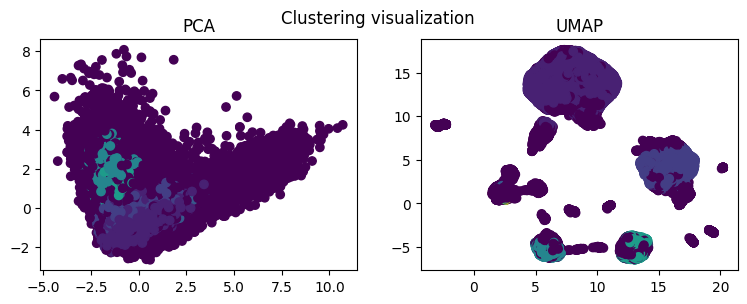

Cluster 0 size: 29774


,Track,Artist
0,Regenbogenfarben,Kerstin Ott
1,Girl At Home,Taylor Swift
2,Morir Tres Veces,Mœnia
3,ลึก ลึก (Deep),SCRUBB
4,Amame,Alexandre Pires
5,H.I.E.L.O.,Duki
6,Lay It All on Me (feat. Ed Sheeran),Rudimental
7,Jab Tak (Redux),Armaan Malik
8,Ni Mandándote A Hacer,Calibre 50
9,Pobre soñador,El Tri


Top 10 genres in the cluster: ['rock', 'pop', 'latin', 'dance pop', 'latin pop', 'classic rock', 'mellow gold', 'soft rock', 'pop rock', 'regional mexican']
Cluster 1 size: 14475


,Track,Artist
0,Туманы,Max Barskih
1,Comes and Goes 와리가리,HYUKOH
2,Trivia 承 : Love,BTS
3,Spinning Around,Kylie Minogue
4,Divane,Yaşar
5,Real Life,Duke Dumont
6,Haus am See,Peter Fox
7,Helwa,Gilli
8,Maintenant - Version radio,Les Enfoirés
9,Private Dancer - Single Edit,Tina Turner


Top 10 genres in the cluster: ['pop', 'dance pop', 'latin', 'rock', 'latin pop', 'tropical', 'post-teen pop', 'turkish pop', 'trap latino', 'desi pop']
Cluster 5 size: 2747


,Track,Artist
0,Broken Clocks,SZA
1,skittles,Karpe
2,Crazy = Genius,Panic! At The Disco
3,242,Ati242
4,You Got It,Vedo
5,occh1 purpl3 - feat. Marracash,tha Supreme
6,Primo,RAF Camora
7,Fuori E Dentro (feat. tha Supreme),Gemitaiz
8,FML,Arizona Zervas
9,ЗЕЛЕНЬ,GONE.Fludd


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'pop', 'trap', 'southern hip hop', 'dance pop', 'pop urbaine', 'french hip hop']
Cluster 4 size: 2431


,Track,Artist
0,Ballin,Luciano
1,nasty,Ariana Grande
2,7 sur 7,Koba LaD
3,VORREI,PSICOLOGI
4,Cut Me Off (feat. D-Block Europe),Yxng Bane
5,Vertigini,Tedua
6,"Calipso (with Dardust) (feat. Sfera Ebbasta, M...",Charlie Charles
7,Ik Ga Hard,The Partysquad
8,BREBBIA 2012,Massimo Pericolo
9,Medusa,SNIK


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop urbaine', 'french hip hop', 'rap francais', 'pop', 'trap', 'dance pop', 'gangster rap']
Cluster 2 size: 338


,Track,Artist
0,Shouldn't Be,Luke Chiang
1,Les Bicyclettes de Belsize,Engelbert Humperdinck
2,Panalangin,Moonstar88
3,Now and Forever,Air Supply
4,Ikaw At Ako,TJ Monterde
5,Slow Dancing in a Burning Room - Acoustic,John Mayer
6,Don't,GANGGA
7,Burn,Phillipa Soo
8,Idhayathai Yedho Ondru,Harris Jayaraj
9,With You,Matt Simons


Top 10 genres in the cluster: ['adult standards', 'pop', 'pop rock', 'neo mellow', 'vocal jazz', 'lounge', 'soul', 'latin pop', 'mellow gold', 'indonesian pop']
Cluster 7 size: 145


,Track,Artist
0,Háblame De Ti,Banda MS de Sergio Lizárraga
1,Me Gusta Tu Vieja,Banda MS de Sergio Lizárraga
2,El Primer Lugar,La Original Banda El Limón de Salvador Lizárraga
3,Te Volvería A Elegir,Calibre 50
4,Te Metiste,Ariel Camacho y Los Plebes Del Rancho
5,Por Enamorarme,Los Plebes del Rancho de Ariel Camacho
6,Me Vas a Extrañar,Banda MS de Sergio Lizárraga
7,Mujer De Pierda,Gerardo Ortiz
8,Cuando Te Entregues A Él,Banda Los Recoditos
9,La Doble Cara,Banda Carnaval


Top 10 genres in the cluster: ['regional mexican', 'corrido', 'nuevo regional mexicano', 'banda', 'ranchera', 'norteno', 'sierreno', 'deep regional mexican', 'musica popular colombiana', 'colombian pop']


In [28]:
clustering = DBSCAN(eps=1.1, min_samples=X.shape[1] * 2, n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Number of clusters: 5
Percentage of noise points: 25.66%
CH-index value: 5726.25


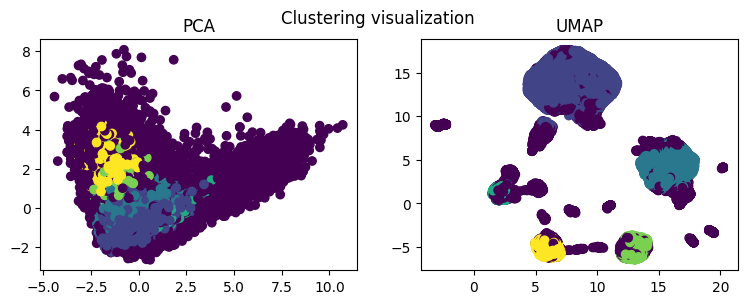

Cluster 0 size: 31975


,Track,Artist
0,Regenbogenfarben,Kerstin Ott
1,H.I.E.L.O.,Duki
2,Amame,Alexandre Pires
3,Girl At Home,Taylor Swift
4,ลึก ลึก (Deep),SCRUBB
5,Morir Tres Veces,Mœnia
6,Lay It All on Me (feat. Ed Sheeran),Rudimental
7,Rüyalarda Buruşmuşum,Adamlar
8,Emannavoo,Anirudh Ravichander
9,Pobre soñador,El Tri


Top 10 genres in the cluster: ['rock', 'pop', 'latin', 'dance pop', 'latin pop', 'classic rock', 'mellow gold', 'soft rock', 'pop rock', 'regional mexican']
Cluster 1 size: 15942


,Track,Artist
0,Туманы,Max Barskih
1,Trivia 承 : Love,BTS
2,Spinning Around,Kylie Minogue
3,Comes and Goes 와리가리,HYUKOH
4,Haus am See,Peter Fox
5,Divane,Yaşar
6,Real Life,Duke Dumont
7,Elevator (feat. Timbaland),Flo Rida
8,Private Dancer - Single Edit,Tina Turner
9,Love Profusion,Madonna


Top 10 genres in the cluster: ['pop', 'dance pop', 'latin', 'rock', 'latin pop', 'tropical', 'post-teen pop', 'turkish pop', 'trap latino', 'desi pop']
Cluster 3 size: 3662


,Track,Artist
0,Broken Clocks,SZA
1,skittles,Karpe
2,Primo,RAF Camora
3,You Got It,Vedo
4,occh1 purpl3 - feat. Marracash,tha Supreme
5,I Don't Mind (feat. Juicy J),Usher
6,Le regard des gens,Nekfeu
7,242,Ati242
8,Crazy = Genius,Panic! At The Disco
9,ЗЕЛЕНЬ,GONE.Fludd


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'trap', 'pop', 'southern hip hop', 'dance pop', 'pop urbaine', 'french hip hop']
Cluster 4 size: 3447


,Track,Artist
0,7 sur 7,Koba LaD
1,nasty,Ariana Grande
2,Vertigini,Tedua
3,"Calipso (with Dardust) (feat. Sfera Ebbasta, M...",Charlie Charles
4,Ik Ga Hard,The Partysquad
5,Ballin,Luciano
6,ALYX (feat. Capo Plaza),Lazza
7,Zły,Szpaku
8,VORREI,PSICOLOGI
9,Medusa,SNIK


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop urbaine', 'french hip hop', 'gangster rap', 'trap', 'pop', 'rap francais', 'dance pop']
Cluster 2 size: 1501


,Track,Artist
0,Tum Jab Paas,Prateek Kuhad
1,Cuando Tú Me Besas (Version Mariachi),El Bebeto
2,Coming Home,Leon Bridges
3,Get It While You Can,Janis Joplin
4,Dive,Ed Sheeran
5,Me Pones A Temblar,Diferente Nivel
6,Me Bebi Tu Recuerdo,Galy Galiano
7,Que Te Vaya Bonito,Vicente Fernández
8,Bohemio De Aficion,Vicente Fernández
9,Supiste Hacerme Mal,Edwin Luna y La Trakalosa de Monterrey


Top 10 genres in the cluster: ['regional mexican', 'corrido', 'nuevo regional mexicano', 'ranchera', 'norteno', 'banda', 'pop', 'adult standards', 'latin pop', 'rock']


In [29]:
clustering = DBSCAN(eps=1.2, min_samples=X.shape[1] * 2, n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

## Komentarz

W przypadku DBSCAN obserwujemy duży poziom szumu, co utrudnia dokładne dopasowanie klastrów. Wysoki procent szumu (34%) oznacza, że wiele punktów nie zostało przypisanych do żadnego klastra. Jednak biorąc pod uwagę złożoność i zróżnicowanie gatunków muzycznych, można zaakceptować ten poziom szumu. Finalna liczba klastrów wynosząca 11 wydaje się sensowna, uwzględniając różnorodność grup muzycznych.

W porównaniu do k-means, klastry w DBSCAN mogą być lepiej widoczne lub lepiej interpretowalne. DBSCAN jest w stanie wyodrębnić klastry o bardziej skomplikowanych kształtach, co może być korzystne w przypadku zbiorów danych o dużym zróżnicowaniu. Jednak należy pamiętać, że DBSCAN ma trudności z identyfikacją klastrów w przypadku dużego poziomu szumu, co może wpływać na interpretowalność wyników.

DBSCAN ma dwie zasadnicze wady: trudny dobór hiperparametrów oraz podatność na szum. W szczególności to drugie widać, jeżeli w naszym zbiorze ciągle znajduje on dużo szumu - to oznaka, że mamy zmienną gęstość w danych i przydałoby się coś adaptacyjnego, jak OPTICS albo HDBSCAN. OPTICS jest bardziej zoptymalizowany pod pamięć niż szybkość w scikit-learn, plus ma raczej nieintuicyjne hiperparametry (może nawet bardziej, niż DBSCAN), więc wykorzystamy tutaj HDBSCAN.

Jego głównym hiperparametrem jest `min_cluster_size`, czyli po prostu minimalna liczba punktów, aby stworzyć klaster. Dodatkowo `min_samples` ma takie samo znaczenie, jak w DBSCAN, czyli jest to minimalna liczba punktów, aby utworzyć punkt typu CORE. Domyślnie są one równe, ale oczywiście można ustawić `min_samples` (sporo) mniejsze od `min_cluster_size`, i dostrajać oba.

Co ważne, HDBSCAN potrafi cache'ować wyniki obliczeń dla stałego `min_samples`, dlatego warto je czasem ustawiać choćby tylko z tego powodu. Caching wymaga też podania argumentu `memory`. Przyspiesza to drugie i kolejne wykonania algorytmu o rzędy wielkości.

Number of clusters: 20
Percentage of noise points: 3.06%
CH-index value: 1718.49


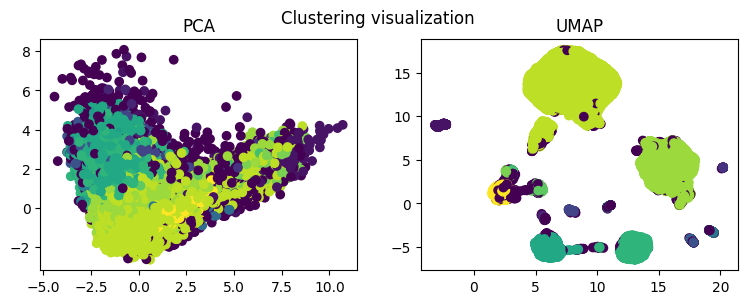

Cluster 17 size: 37670


,Track,Artist
0,An Angel,The Kelly Family
1,Vagarinho,Palavra Cantada
2,Two Dozen Roses,Shenandoah
3,Die Jahresuhr,Rolf Zuckowski
4,"Next To You, Next To Me",Shenandoah
5,Church On Cumberland Road,Shenandoah
6,Define Dancing,Thomas Newman
7,Lagrimas De Amor,Camela
8,Ein Vogel wollte Hochzeit machen - 1,Rolf Zuckowski
9,blind,ROLE MODEL


Top 10 genres in the cluster: ['rock', 'pop', 'latin', 'classic rock', 'dance pop', 'latin pop', 'mellow gold', 'soft rock', 'album rock', 'pop rock']
Cluster 16 size: 20222


,Track,Artist
0,Suntoucher,Groove Armada
1,Y Vete Ya,Leo Mattioli
2,Xote Dos Milagres,Falamansa
3,Akhir Cerita Cinta - Ost. Cinta Silver (Re-arr...,Glenn Fredly
4,Akhir Cerita Cinta,Glenn Fredly
5,Januari,Glenn Fredly
6,De Gloria en Gloria,Marco Barrientos
7,Ven Espíritu Ven,Marco Barrientos
8,Oh! Chuva,Falamansa
9,Sous le ciel de Paris,Zaz


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'latin', 'latin pop', 'tropical', 'classic rock', 'trap latino', 'album rock', 'desi pop']
Cluster 12 size: 5594


,Track,Artist
0,Desconocidos,Mau y Ricky
1,lowkey,NIKI
2,Ball Tongue,Korn
3,Divine,Korn
4,La Grosera,Mau y Ricky
5,PAM,Justin Quiles
6,Superheroes,Stormzy
7,Right Now,Korn
8,Juraste,Justin Quiles
9,miSs U <3,Alex Ceesay


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'trap', 'pop', 'southern hip hop', 'dance pop', 'pop urbaine', 'french hip hop']
Cluster 11 size: 5172


,Track,Artist
0,Boys Like You,360
1,Bloodfeather,Highly Suspect
2,Never Ever (feat. Sarah),The Rubens
3,My Name Is Human,Highly Suspect
4,STFU,mansionz
5,Nothing to Love About Love,Peking Duk
6,Ghetto Soldier,Ky-Mani Marley
7,I Don’t Even Know You Anymore (feat. Bazzi & L...,Netsky
8,The Walk,Mayer Hawthorne
9,Falling In Love (Is Hard On The Knees),Aerosmith


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop urbaine', 'french hip hop', 'gangster rap', 'trap', 'pop', 'southern hip hop', 'rap francais']
Cluster 19 size: 2450


,Track,Artist
0,The Crow & the Butterfly,Shinedown
1,El Viejón,La Adictiva Banda San José de Mesillas
2,Te Dirán,La Adictiva Banda San José de Mesillas
3,La Princesa,La Adictiva Banda San José de Mesillas
4,45,Shinedown
5,Si Ya Lo Sabe Dios,La Adictiva Banda San José de Mesillas
6,Un Fin en Culiacán,La Adictiva Banda San José de Mesillas
7,En la Sierra y la Ciudad (La China),La Adictiva Banda San José de Mesillas
8,Hombre Libre,La Adictiva Banda San José de Mesillas
9,When She Loved Me,Sarah McLachlan


Top 10 genres in the cluster: ['regional mexican', 'corrido', 'nuevo regional mexicano', 'ranchera', 'norteno', 'banda', 'adult standards', 'rock', 'pop', 'latin pop']
Cluster 14 size: 942


,Track,Artist
0,The Whistler,The White Buffalo
1,Lupaan,BEHM
2,From Can to Can't,Corey Taylor
3,Never Had No One Ever - 2017 Master,The Smiths
4,Kipee,Antti Tuisku
5,Längesen (feat. Veronica Maggio),Petter
6,Nöjd? - Radio Version,Veronica Maggio
7,Duele,Carla Morrison
8,Mono Verde,Gerardo Ortiz
9,Gloomy Sunday (with Teddy Wilson & His Orchest...,Billie Holiday


Top 10 genres in the cluster: ['rock', 'pop', 'regional mexican', 'corrido', 'filmi', 'nuevo regional mexicano', 'adult standards', 'classic rock', 'latin', 'latin pop']
Cluster 0 size: 414


,Track,Artist
0,Burning,Ludovico Einaudi
1,Shawshank Prison - Stoic Theme,Thomas Newman
2,Road To Perdition,Thomas Newman
3,Je T’aime,Lara Fabian
4,Nuvole Bianche,Ludovico Einaudi
5,Careful What You Wish For,Eminem
6,Las Heladas,Los Tucanes De Tijuana
7,One Fine Day - Remastered,Natalie Merchant
8,I Am You,Nightmares On Wax
9,Tatuaże z henny,Guzior


Top 10 genres in the cluster: ['corrido', 'regional mexican', 'nuevo regional mexicano', 'rock', 'norteno', 'sleep', 'ranchera', 'rap', 'adult standards', 'classic rock']
Cluster 3 size: 303


,Track,Artist
0,Soy Mencho,Lenin Ramírez
1,Soy El Diablo - Remix,Natanael Cano
2,No Eh Cambiado,Junior H
3,All Your Exes,Julia Michaels
4,Rolling One,Lenin Ramírez
5,Miami Vibe,Adriel Favela
6,I Want It,Juice WRLD
7,Miss You,Louis Tomlinson
8,Scars,Brennan Savage
9,.357,HAVAL


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop urbaine', 'french hip hop', 'pop', 'nuevo regional mexicano', 'pop rap', 'corrido', 'regional mexican', 'corridos tumbados']
Cluster 7 size: 261


,Track,Artist
0,Desde cero (con Melendi),Beret
1,Que El Eterno Sol,Mirabai Ceiba
2,Desesperado,Andrés Cepeda
3,Meethi Boliyaan,Amit Trivedi
4,Ulit Ulit,John Roa
5,Favorite Part Of Me,Astrid S
6,Leave Your Lover,Sam Smith
7,Nothing Really Matters,Mr. Probz
8,Imperfeito,Anderson Freire
9,Ere bara jag,Danny Saucedo


Top 10 genres in the cluster: ['pop', 'dance pop', 'post-teen pop', 'rock', 'desi pop', 'modern bollywood', 'r&b', 'adult standards', 'ranchera', 'classic rock']
Cluster 15 size: 180


,Track,Artist
0,The Mission,Ennio Morricone
1,On Earth As It Is In Heaven,Ennio Morricone
2,Jessica's Theme From The Man From Snowy River,Stan Whitmire
3,Nemo Egg (Main Title),Thomas Newman
4,Back To The Future: Back To The Future - From ...,Alan Silvestri
5,"Theme - From ""Emma""",Rachel Portman
6,When You Wish Upon A Star,Stan Whitmire
7,Neville's Waltz,Patrick Doyle
8,Porz Goret,Yann Tiersen
9,Le Onde,Ludovico Einaudi


Top 10 genres in the cluster: ['soundtrack', 'classical', 'compositional ambient', 'adult standards', 'sleep', 'post-romantic era', 'neo-classical', 'impressionism', 'middle earth', 'lullaby']


In [30]:
from hdbscan import HDBSCAN


clustering = HDBSCAN(memory="tmp")
clustering.fit(X)

dbscan_analyzer = HDBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Domyślne `min_cluster_size` to zaledwie 5, a mimo tego HDBSCAN wcale nie znalazł tak dużo klastrów - pokazuje to jego zdolność do adaptacji do zbioru danych. CH-index nie jest zbyt wysoki, pomimo tego, że niektóre klastry wydają się ciekawe i inne niż w k-means. Pokazuje to też, że klastry pewnie nie są sferyczne.

**Zadanie 6 (2 punkty)**

Dokonaj ręcznego tuningu hiperparametrów `min_cluster_size` oraz `min_samples`. Pamiętaj, że przy stałym `min_samples` możesz praktycznie za darmo zmieniać `min_cluster_size` dzięki cache'owaniu.

Skomentuj finalne wyniki. Czy udało się uzyskać sensowne, interpretowalne klastry? Czy są one w jakimś stopniu nieoczywiste, tj. czy otrzymaliśmy jakąś nową wiedzę dzięki klasteryzacji? Czy CH-index wskazał sensownie na jakość klasteryzacji w HDBSCAN?

min_cluster_size: 5, min_samples: 2, CH-index: 453.70540438653154
min_cluster_size: 10, min_samples: 2, CH-index: 1290.3227196694038
min_cluster_size: 15, min_samples: 2, CH-index: 1451.2295998725583
min_cluster_size: 20, min_samples: 2, CH-index: 1577.5078578091081
min_cluster_size: 5, min_samples: 5, CH-index: 1575.6648136007543
min_cluster_size: 10, min_samples: 5, CH-index: 1654.176172381369
min_cluster_size: 15, min_samples: 5, CH-index: 1734.607496311609
min_cluster_size: 20, min_samples: 5, CH-index: 1656.9347005078027
min_cluster_size: 5, min_samples: 10, CH-index: 2113.0873940200236
min_cluster_size: 10, min_samples: 10, CH-index: 1807.7916954923044
min_cluster_size: 15, min_samples: 10, CH-index: 2012.2101591664602
min_cluster_size: 20, min_samples: 10, CH-index: 1978.1436905731064
Number of clusters: 15
Percentage of noise points: 3.79%
CH-index value: 2331.28


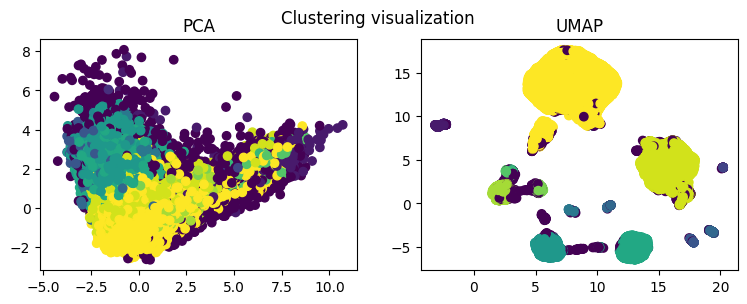

Cluster 14 size: 37407


,Track,Artist
0,Lloro Por Ti,Enrique Iglesias
1,Falta Tanto Amor,Enrique Iglesias
2,No Me Digas Que No,Enrique Iglesias
3,4th Chamber,GZA
4,Dirty Dancer,Enrique Iglesias
5,Bailando - English Version,Enrique Iglesias
6,Why Not Me?,Enrique Iglesias
7,Somebody's Me,Enrique Iglesias
8,Heart Attack,Enrique Iglesias
9,blind,ROLE MODEL


Top 10 genres in the cluster: ['rock', 'pop', 'latin', 'classic rock', 'dance pop', 'latin pop', 'mellow gold', 'soft rock', 'album rock', 'pop rock']
Cluster 13 size: 19957


,Track,Artist
0,All The People In The World,Safri Duo
1,Hope,Jack Johnson
2,Mareo,Babasónicos
3,Ingrediente,Babasónicos
4,El Maestro - En Vivo,Babasónicos
5,Yegua - En Vivo,Babasónicos
6,Puesto - En Vivo,Babasónicos
7,Yegua - [Blank],Babasónicos
8,El Colmo - [Blank],Babasónicos
9,Wati House,Sexion d'Assaut


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'latin', 'latin pop', 'tropical', 'classic rock', 'trap latino', 'desi pop', 'rock en espanol']
Cluster 8 size: 5474


,Track,Artist
0,My Way (feat. Monty),Fetty Wap
1,Sorry Not Sorry,Bryson Tiller
2,MAMACITA,Black Eyed Peas
3,6 Inch (feat. The Weeknd),Beyoncé
4,TOP CLASS,Dree Low
5,Gone Forever,Three Days Grace
6,TATUAGGI (feat. ARIETE),PSICOLOGI
7,Okay,Chase Atlantic
8,Ricordami,Tommaso Paradiso
9,Little Lion Man,Tonight Alive


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'trap', 'pop', 'southern hip hop', 'dance pop', 'pop urbaine', 'french hip hop']
Cluster 7 size: 5080


,Track,Artist
0,Autostrada Del Sole,Silent Bob
1,Traición,Miranda!
2,You Don't Know Me,Jax Jones
3,ELEGANTE (feat. Sfera Ebbasta),DrefGold
4,Stato Di Ebbrezza,Silent Bob
5,GIOVANE RONDO,Rondodasosa
6,Give Dem,Frenna
7,"WEEKEND (feat. Lazza, Madame & Massimo Pericolo)",BLOODY VINYL
8,Made In Favela,Hungria Hip Hop
9,G.U.Y.,Lady Gaga


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop urbaine', 'french hip hop', 'gangster rap', 'trap', 'pop', 'southern hip hop', 'rap francais']
Cluster 12 size: 2665


,Track,Artist
0,Perfect - Acoustic,Ed Sheeran
1,她整晚在寫信,Janice Vidal
2,Hearts Don't Break Around Here,Ed Sheeran
3,Aan De Kust,BLØF
4,Canción de Amor,Lisandro Aristimuño
5,Saturno,Pablo Alborán
6,No lo Engañes Más,Hernan y La Champion's Liga
7,Fool For You,Snoh Aalegra
8,Frozen,Sabrina Claudio
9,Te Volvería A Elegir,Calibre 50


Top 10 genres in the cluster: ['regional mexican', 'corrido', 'nuevo regional mexicano', 'ranchera', 'norteno', 'rock', 'banda', 'adult standards', 'pop', 'latin pop']
Cluster 11 size: 882


,Track,Artist
0,WA-R-R,Colde
1,The Lion's Roar,First Aid Kit
2,Alle gutta,Hver gang vi møtes
3,"Earned It (Fifty Shades Of Grey) - From The ""F...",The Weeknd
4,El Mundo,Pablo López
5,Yaad Hai Na,Arijit Singh
6,Janam Janam,Arijit Singh
7,Así es Mi Cartel,Traviezoz de la Zierra
8,Bust Your Knee Caps,Pomplamoose
9,Gloomy Sunday (with Teddy Wilson & His Orchest...,Billie Holiday


Top 10 genres in the cluster: ['rock', 'pop', 'regional mexican', 'corrido', 'filmi', 'nuevo regional mexicano', 'adult standards', 'classic rock', 'latin', 'sierreno']
Cluster 4 size: 495


,Track,Artist
0,Per uno come me,Negramaro
1,She's Like A Star,Taio Cruz
2,End of the Day,One Direction
3,十萬毫升淚水,Tanya Chua
4,Un Hombre Normal,Espinoza Paz
5,Grow Old Die Young,ONE OK ROCK
6,How Long Will I Love You - Bonus Track,Ellie Goulding
7,Africain,Sexion d'Assaut
8,Meethi Boliyaan,Amit Trivedi
9,Scars,James Bay


Top 10 genres in the cluster: ['pop', 'dance pop', 'turkish pop', 'rock', 'desi pop', 'post-teen pop', 'adult standards', 'modern bollywood', 'r&b', 'latin']
Cluster 0 size: 411


,Track,Artist
0,Get It Wet,Twista
1,Renegade,JAY-Z
2,One Fine Day - Remastered,Natalie Merchant
3,Careful What You Wish For,Eminem
4,Las Heladas,Los Tucanes De Tijuana
5,Stand Here With Me,Creed
6,Tera Chehra,Adnan Sami
7,Los Tres Gallos,La Arrolladora Banda El Limón De Rene Camacho
8,Mi Gusto Es,La Arrolladora Banda El Limón De Rene Camacho
9,Tatuaże z henny,Guzior


Top 10 genres in the cluster: ['corrido', 'regional mexican', 'nuevo regional mexicano', 'rock', 'norteno', 'sleep', 'ranchera', 'rap', 'adult standards', 'classic rock']
Cluster 5 size: 281


,Track,Artist
0,The Weekend,SZA
1,do re mi,blackbear
2,Barrio Prendido,The La Planta
3,Dark Light,Night Lovell
4,Pray,Sam Smith
5,El Problema,Cornelio Vega y su Dinastia
6,MDMA,Bonez MC
7,Тело,LSP
8,Balaclava (Prod. DJ Tape & Serge Laconic),Big Baby Tape
9,L.O.V.E. Machine,W.A.S.P.


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop urbaine', 'french hip hop', 'nuevo regional mexicano', 'pop', 'corrido', 'pop rap', 'regional mexican', 'corridos tumbados']
Cluster 3 size: 233


,Track,Artist
0,Mac 11,Ninho
1,Solfege,Immune
2,Sol y Luna,Duki
3,On The Road (feat. Meek Mill & Lil Baby),Post Malone
4,Pretty Girl,Maggie Lindemann
5,Boston George,Lacrim
6,Veux-tu ?,Lacrim
7,Øjne På Mig (feat. Kesi),ICEKIID
8,Just Like Me (feat. Young Thug),A Boogie Wit da Hoodie
9,Kall,Ant Wan


Top 10 genres in the cluster: ['rap', 'pop rap', 'hip hop', 'trap', 'pop urbaine', 'gangster rap', 'german hip hop', 'southern hip hop', 'french hip hop', 'east coast hip hop']


In [31]:
min_cluster_size_values = [5, 10, 15, 20]
min_samples_values = [2, 5, 10]
best_ch_index = -1
best_clustering = None

for min_samples in min_samples_values:
    for min_cluster_size in min_cluster_size_values:
        clustering = HDBSCAN(
            min_cluster_size=min_cluster_size, min_samples=min_samples, memory="tmp"
        )
        clustering.fit(X)

        ch_index = calinski_harabasz_score(X, clustering.labels_)
        print(
            f"min_cluster_size: {min_cluster_size}, min_samples: {min_samples}, CH-index: {ch_index}"
        )

        if ch_index > best_ch_index:
            best_ch_index = ch_index
            best_clustering = clustering

hdb_scan_analyzer = HDBSCANAnalyzer(df_songs_info, clustering_visualizer)
hdb_scan_analyzer.analyze_clustering(X, best_clustering)

## Komentarz

Udało się uzyskać sensowne i interpretowalne klastry. Wartość CH-index wskazuje na wysoką jakość klasteryzacji w przypadku HDBSCAN. Wyższa wartość CH-index oznacza lepszą separację klastrów, a wynik 2331.28 wskazuje na dobrą jakość uzyskanego podziału.

## Zadanie dodatkowe (3 punkty)

Klasteryzacja hierarchiczna jest przydatnym narzędziem, dającym od razu znaczną ilość informacji co do klasteryzacji, ale ze względu na złożoność nadaje się tylko do mniejszych zbiorów danych. Takim zbiorem jest dobrze nam już znany [Ames housing](https://www.openintro.org/book/statdata/?data=ames).

1. Załaduj zbiór i dokonaj odpowiedniego preprocessingu. Zwizualizuj go z pomocą PCA oraz UMAP.
2. Zastosuj klasteryzację hierarchiczną do tego zbioru, wykorzystując metrykę euklidesową i Ward linkage.
3. Narysuj dendrogram dla wynikowej klasteryzacji. Czy widać jakąś strukturę klastrującą? Sprawdź kilka przykładowych próbek, które wydają się podobne - czy faktycznie te domy są podobne?
4. Wybierz klasteryzację, która wydaje się najbardziej stabilna, tj. ma najdłuższe pionowe linie na dendrogramie. Sprawdź jej CH-index, oraz zwizualizuj ją za pomocą PCA oraz UMAP. Ile ma ona klastrów? Czy wydaje się ona sensowna? Wypisz przykładowe domy z klastrów. Czy faktycznie wskazują na zróżnicowanie klastrów?
5. Porównaj tę klasteryzację z k-means (dokonaj tuningu liczby klastrów z pomocą CH-index) oraz HDBSCAN. Ile klastrów wybrały te metody? Czy na wizualizacji PCA i UMAP dają lepsze, czy gorsze wyniki od klasteryzacji hierarchicznej?

In [70]:
df = pd.read_csv("ames_data.csv")

# remove dots from names to match data_description.txt
df.columns = [col.replace(".", "") for col in df.columns]

df = df.drop(["Order", "PID"], axis="columns")
df = df.loc[~df["Neighborhood"].isin(["GrnHill", "Landmrk"]), :]

df = df.loc[df["GrLivArea"] <= 4000, :]

df["SalePrice"] = np.log1p(df["SalePrice"])


def replace_na(df: pd.DataFrame, col: str, value) -> None:
    df.loc[:, col] = df.loc[:, col].fillna(value)


# Alley : data description says NA means "no alley access"
replace_na(df, "Alley", value="None")

# BedroomAbvGr : NA most likely means 0
replace_na(df, "BedroomAbvGr", value=0)

# BsmtQual etc : data description says NA for basement features is "no basement"
replace_na(df, "BsmtQual", value="No")
replace_na(df, "BsmtCond", value="No")
replace_na(df, "BsmtExposure", value="No")
replace_na(df, "BsmtFinType1", value="No")
replace_na(df, "BsmtFinType2", value="No")
replace_na(df, "BsmtFullBath", value=0)
replace_na(df, "BsmtHalfBath", value=0)
replace_na(df, "BsmtUnfSF", value=0)

# Condition : NA most likely means Normal
replace_na(df, "Condition1", value="Norm")
replace_na(df, "Condition2", value="Norm")

# Electrical : NA most likely means standard
replace_na(df, "Electrical", value="SBrkr")

# External stuff : NA most likely means average
replace_na(df, "ExterCond", value="TA")
replace_na(df, "ExterQual", value="TA")

# Fence : data description says NA means "no fence"
replace_na(df, "Fence", value="No")

# Functional : data description says NA means typical
replace_na(df, "Functional", value="Typ")

# GarageType etc : data description says NA for garage features is "no garage"
replace_na(df, "GarageType", value="No")
replace_na(df, "GarageFinish", value="No")
replace_na(df, "GarageQual", value="No")
replace_na(df, "GarageCond", value="No")
replace_na(df, "GarageArea", value=0)
replace_na(df, "GarageCars", value=0)

# HalfBath : NA most likely means no half baths above grade
replace_na(df, "HalfBath", value=0)

# HeatingQC : NA most likely means typical
replace_na(df, "HeatingQC", value="Ta")

# KitchenAbvGr : NA most likely means 0
replace_na(df, "KitchenAbvGr", value=0)

# KitchenQual : NA most likely means typical
replace_na(df, "KitchenQual", value="TA")

# LotFrontage : NA most likely means no lot frontage
replace_na(df, "LotFrontage", value=0)

# LotShape : NA most likely means regular
replace_na(df, "LotShape", value="Reg")

# MasVnrType : NA most likely means no veneer
replace_na(df, "MasVnrType", value="None")
replace_na(df, "MasVnrArea", value=0)

# MiscFeature : data description says NA means "no misc feature"
replace_na(df, "MiscFeature", value="No")
replace_na(df, "MiscVal", value=0)

# OpenPorchSF : NA most likely means no open porch
replace_na(df, "OpenPorchSF", value=0)

# PavedDrive : NA most likely means not paved
replace_na(df, "PavedDrive", value="N")

# PoolQC : data description says NA means "no pool"
replace_na(df, "PoolQC", value="No")
replace_na(df, "PoolArea", value=0)

# SaleCondition : NA most likely means normal sale
replace_na(df, "SaleCondition", value="Normal")

# ScreenPorch : NA most likely means no screen porch
replace_na(df, "ScreenPorch", value=0)

# TotRmsAbvGrd : NA most likely means 0
replace_na(df, "TotRmsAbvGrd", value=0)

# Utilities : NA most likely means all public utilities
replace_na(df, "Utilities", value="AllPub")

# WoodDeckSF : NA most likely means no wood deck
replace_na(df, "WoodDeckSF", value=0)

# CentralAir : NA most likely means No
replace_na(df, "CentralAir", value="N")

# EnclosedPorch : NA most likely means no enclosed porch
replace_na(df, "EnclosedPorch", value=0)

# FireplaceQu : data description says NA means "no fireplace"
replace_na(df, "FireplaceQu", value="No")
replace_na(df, "Fireplaces", value=0)

# SaleCondition : NA most likely means normal sale
replace_na(df, "SaleCondition", value="Normal")

df = df.replace(
    {
        "MSSubClass": {
            20: "SC20",
            30: "SC30",
            40: "SC40",
            45: "SC45",
            50: "SC50",
            60: "SC60",
            70: "SC70",
            75: "SC75",
            80: "SC80",
            85: "SC85",
            90: "SC90",
            120: "SC120",
            150: "SC150",
            160: "SC160",
            180: "SC180",
            190: "SC190",
        },
        "MoSold": {
            1: "Jan",
            2: "Feb",
            3: "Mar",
            4: "Apr",
            5: "May",
            6: "Jun",
            7: "Jul",
            8: "Aug",
            9: "Sep",
            10: "Oct",
            11: "Nov",
            12: "Dec",
        },
    }
)

df = df.replace(
    {
        "Alley": {"None": 0, "Grvl": 1, "Pave": 2},
        "BsmtCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "BsmtExposure": {"No": 0, "Mn": 1, "Av": 2, "Gd": 3},
        "BsmtFinType1": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtFinType2": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "FireplaceQu": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "Functional": {
            "Sal": 1,
            "Sev": 2,
            "Maj2": 3,
            "Maj1": 4,
            "Mod": 5,
            "Min2": 6,
            "Min1": 7,
            "Typ": 8,
        },
        "GarageCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "GarageQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "HeatingQC": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "KitchenQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "LandSlope": {"Sev": 1, "Mod": 2, "Gtl": 3},
        "LotShape": {"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4},
        "PavedDrive": {"N": 0, "P": 1, "Y": 2},
        "PoolQC": {"No": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
        "Street": {"Grvl": 1, "Pave": 2},
        "Utilities": {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4},
    }
)

y = df.pop("SalePrice")

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.3, random_state=0
)

X_train_num = X_train.select_dtypes(exclude="object")

numerical_pipeline = make_pipeline(SimpleImputer(strategy="median"), MinMaxScaler())

X_train_num = numerical_pipeline.fit_transform(X_train_num)

categorical_features = X_train.select_dtypes(include="object").columns
numerical_features = X_train.select_dtypes(exclude="object").columns

column_transformer = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
        ("num", SimpleImputer(strategy="median"), numerical_features),
    ],
    verbose_feature_names_out=False,
)

column_transformer.fit(X_train)

X_train_mi = column_transformer.transform(X_train)
X_train_mi = column_transformer.transform(X_train)

categorical_features = X_train.select_dtypes(include="object").columns
numerical_features = X_train.select_dtypes(exclude="object").columns

categorical_pipeline = OneHotEncoder(
    drop="first", sparse_output=False, handle_unknown="ignore"
)

numerical_pipeline = make_pipeline(SimpleImputer(strategy="median"), MinMaxScaler())

column_transformer = ColumnTransformer(
    [
        ("cat_pipeline", categorical_pipeline, categorical_features),
        ("num_pipeline", numerical_pipeline, numerical_features),
    ],
    verbose_feature_names_out=False,
)
column_transformer.fit(X_train)

X_train_processed = column_transformer.transform(X_train)
X_test_processed = column_transformer.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning:

Found unknown categories in columns [12, 15, 17] during transform. These unknown categories will be encoded as all zeros



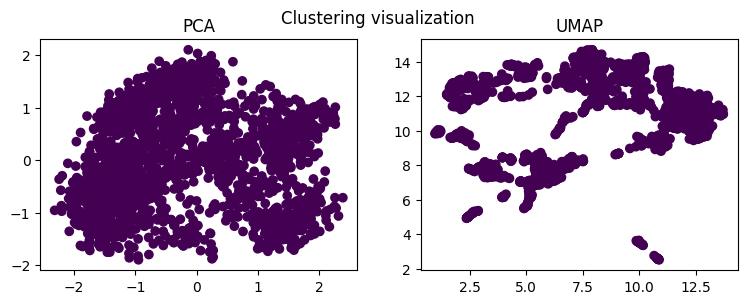

In [75]:
clustering_visualizer = ClusteringVisualizer(X_train_processed)
clustering_visualizer.visualize()

In [78]:
from sklearn.cluster import AgglomerativeClustering

hierarchical_cluster = AgglomerativeClustering(
    n_clusters=3, affinity="euclidean", linkage="ward"
)

labels = hierarchical_cluster.fit_predict(X_train_processed)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



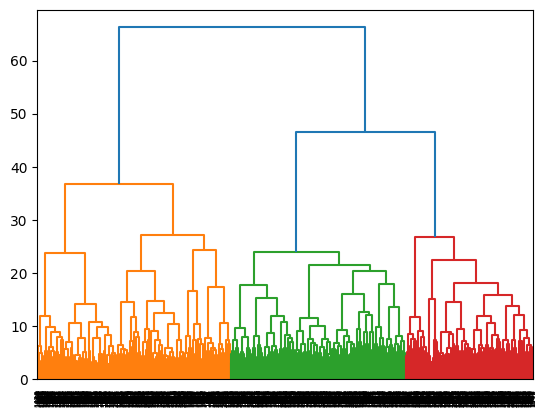

In [84]:
import scipy.cluster.hierarchy as sch

linkage_data = sch.linkage(X_train_processed, method="ward", metric="euclidean")

sch.dendrogram(linkage_data)

plt.show()